# Interpretable Explanations of Black Boxes by Meaningful Perturbation

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-05-21 05:17:01.844690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 05:17:02.349712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jyji/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-21 05:17:02.349750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jyji/miniconda3/envs/tf/lib/python3.9/site-packag

넘파이 행렬을 텐서로 바꿔주는 함수를 작성합니다

In [2]:
def numpy_to_tensor(img, stop_gradient=True):
    if len(img.shape) < 3:
        img = img[..., None]
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.expand_dims(img, 0)
    if stop_gradient:
        img = tf.stop_gradient(img)
    return img

이미지를 전처리하는 함수를 작성합니다

In [3]:
def preprocess(img):
    means = [0.485, 0.456, 0.406] # RGB mean
    stds = [0.229, 0.224, 0.225] # RGB std

    # normalize
    preprocessed_img = img.copy()[:, :, ::-1]
    preprocessed_img = (preprocessed_img - means) / stds

    # to tensor
    preprocessed_img_tensor = numpy_to_tensor(preprocessed_img)

    return preprocessed_img_tensor

이미지 토탈베리에이션을 구하는 함수를 작성합니다

In [5]:
def tv_norm(input, tv_beta=3):
	# img = input[0, :, :, 0]
	row_grad = tf.math.reduce_mean(tf.math.pow(tf.math.abs((input[:-1, :] - input[1:, :])), tv_beta))
	col_grad = tf.math.reduce_mean(tf.math.pow(tf.math.abs((input[:, :-1] - input[:, 1:])), tv_beta))
	return row_grad + col_grad

모델을 불러오는 함수를 작성합니다

In [6]:
def load_model():
    model = tf.keras.applications.vgg19.VGG19(weights='imagenet')

    model = tf.keras.Model(
        inputs=model.inputs,
        outputs=model.outputs
    )

    return model

후처리 및 이미지를 그려줄 함수를 작성합니다

In [7]:
def postprocess(mask, img, blurred_img, show=True):
    mask = mask.numpy()[0]
    mask = (mask - np.min(mask)) / np.max(mask)

    heatmap = cv2.applyColorMap(np.uint8(255*(1-mask)), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    cam = 1.0 * heatmap + np.float32(img) / 255
    cam = cam / np.max(cam)

    img = np.float32(img) / 255
    perturbated = np.multiply(mask, img) + np.multiply(1 - mask, blurred_img)	

    if show:
        plt.figure(figsize=(12, 8))

        plt.subplot(1, 5, 1)
        plt.title('original')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.title('perturbated')
        plt.imshow(perturbated)
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.title('heatmap')
        plt.imshow(heatmap)
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.title('cam')
        plt.imshow(cam)
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.title('mask')
        plt.imshow(mask)
        plt.axis('off')

        plt.show()

이미지를 그려봅니다

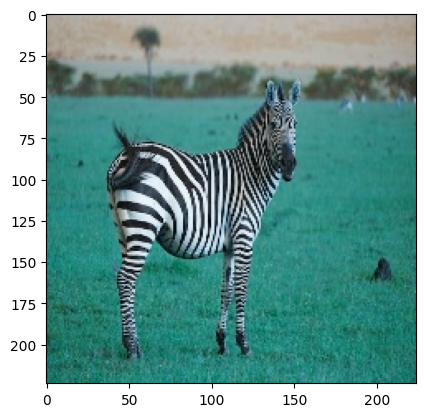

In [9]:
path = 'zebra.jpg'
img = cv2.imread(path)
img = cv2.resize(img, (224, 224))

plt.imshow(img)

하이퍼파라미터를 설정합니다

In [10]:
tv_beta = 3
learning_rate = 0.1
max_iterations = 500
l1_coeff = 0.01
tv_coeff = 0.2

모델을 불러옵니다

In [11]:
model = load_model()

이미지를 불러오고 해당 이미지에 가우시안 필터와 미디안 필터를 적용한 이미지를 생성합니다

그리고 이미지를 마스크할 작은 사이즈의 마스크도 생성합니다

In [12]:
original_img = cv2.imread(path, 1)
original_img = cv2.resize(original_img, (224, 224))
img = np.float32(original_img) / 255
blurred_img1 = cv2.GaussianBlur(img, (11, 11), 5)
blurred_img2 = np.float32(cv2.medianBlur(original_img, 11)) / 255
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
mask_init = np.ones((28, 28), dtype = np.float32)

인풋 이미지와 흐릿한 이미지, 마스크를 전처리합니다

마스크 텐서는 학습이 가능하도록 만들어 줍니다

In [13]:
img = preprocess(img)
blurred_img = preprocess(blurred_img2)
mask = tf.Variable(numpy_to_tensor(mask_init, stop_gradient=False), trainable=True, name='mask')

마스크를 원래 이미지 만큼 늘려줄 이미지 보간 모델을 만들고 최적화 함수를 생성합니다

In [14]:
upsample = tf.keras.layers.UpSampling2D((8, 8), interpolation='bilinear')
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

이미지가 모델을 통해 어떤 클래스로 분류 되는지 확인합니다

In [15]:
target = model(img)
category = tf.get_static_value(tf.argmax(target, -1))[0]

max_iterations 만큼 반복해서 마스크를 학습합니다

마스크는 로스 함수가 가장 낮은 값을 가질 수 있도록 학습 됩니다

$min_{m\in[0,1]} \lambda_1 ||1-m||_1 + \lambda_2 \sum_{u\in [0,1]} ||\triangledown m(u)||_\beta^\beta + \mathbb{E}_\tau [f_c (\Phi (x_0 (\cdot - \tau), m))]$

위 로스식의 각각의 항이 아래 코드의 15번째 라인의 loss를 계산하는 각각의 항과 일치합니다

마지막 항에서 zittering을 추가하는 부분은 noise를 추가하는 것으로 구현되었습니다

In [17]:
for _ in range(max_iterations):
    with tf.GradientTape() as tape:
        upsampled_mask = upsample(mask)
        upsampled_mask = tf.repeat(upsampled_mask, 3, -1)
        
        perturbated_input = tf.multiply(img, upsampled_mask) + tf.multiply(blurred_img, (1-upsampled_mask))

        noise = np.zeros((224, 224, 3), dtype=np.float32)
        cv2.randn(noise, 0, 0.2)
        noise = numpy_to_tensor(noise, stop_gradient=False)
        perturbated_input = perturbated_input + noise
    
        outputs = model(perturbated_input)

        loss = l1_coeff * tf.math.reduce_mean(tf.math.abs(1 - mask)) + tv_coeff * tv_norm(mask[0, :, :, 0], tv_beta) + outputs[0, category]
        
    gradients = tape.gradient(loss, [mask])
    optimizer.apply_gradients(zip(gradients, [mask]))

학습된 마스크를 이미지 보간 방법을 이용해 원래 사이즈대로 만들어 줍니다

In [18]:
upsampled_mask = upsample(mask)

후처리를 통해 히트맵과 perturbed 이미지, 마스크를 그려봅니다

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


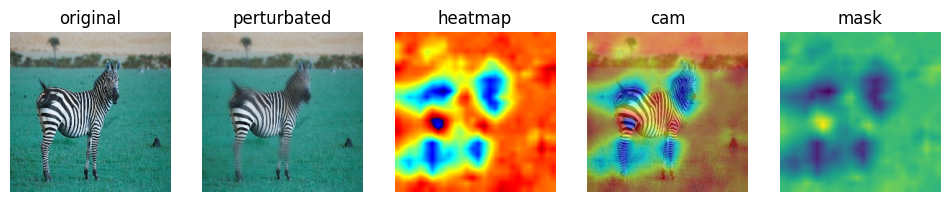

In [19]:
postprocess(upsampled_mask, original_img, blurred_img_numpy)